### 1. 실험환경 Set-up

In [47]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

패키지들을 import 합니다.

In [48]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 10  # 16 -> 10으로 변경
EPOCHS = 25  # 에폭에 따른 가
print(ROOT_PATH)

/aiffel/aiffel


앞으포 필요한 변수들을 생성했습니다.

배치 사이즈만 16에서 10으로 수정해 보았다.

### 2. 데이터 준비하기

In [49]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train -> 5216개, test -> 624개, val -> 16개 들어있습니다. 

val의 개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져오겠습니다.

In [50]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train과 val의 데이터를 모은 다음 train:val을 80:20 으로 분할해줍니다.

In [51]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


??

의료 영상 이미지의 특성상 데이터는 언제나 불충분 하다.

이를 극복하기 위한 방법으로 augmentation 기법을 고려해 볼 수 있다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다.
그래서 augmentation 도입은 신중해야 한다.

그래서 좌우 반전 정도의 augmentation만 도입해 보았다.

train data 안에 정상 이미지 수와 폐렴 이미지 수를 확인해보겠습니다.

In [52]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


정상사진과 폐렴 사진의 개수를 확인할 수 있습니다.

In [53]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [54]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


????

이번에 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다.

데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. 

test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

현재 이미지에는 라벨 데이터가 따로 없습니다.
파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.



In [55]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [56]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [57]:
# train 데이터 셋과 validation 데이터 셋을 만듭니다
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [58]:
for image, label in train_ds.take(1): # train_ds.take(1): 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [59]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [60]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

3. 데이터 시각화

프로젝트 팁: 학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.


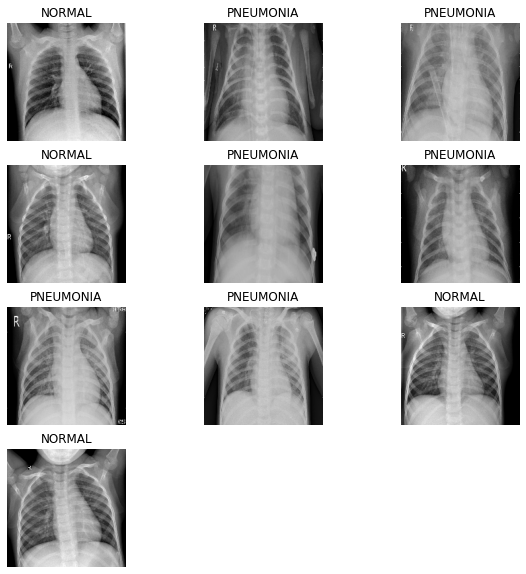

In [61]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

4. CNN 모델링


그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

프로젝트 팁: Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

In [62]:
def conv_block(filters): # 먼저, Convolution block을 만듭니다
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'), # conv_block()의 구성은 Convolution을 두 번 진행하고
        tf.keras.layers.SeparableConv2D(filters, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.BatchNormalization(), # Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
        tf.keras.layers.MaxPool2D() # 그리고 Max Pooling을 합니다.
    ])
    
    return block

Dense Block은 아래와 같이 만듭니다.

In [63]:
def dense_block(units, dropout_rate): # Dense Block 만들기
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='LeakyReLU'),
        tf.keras.layers.BatchNormalization(),  # regularization 기법1
        tf.keras.layers.Dropout(dropout_rate)  # regularization 기법2
    ])
    
    return block

두 가지 regularization 기법이 동시에 사용되고 있는데 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시 되기도 한다. 그러나 실용적으로는 두 방법을 같이 쓰는것이 낫다고 보는 견해도 있다. 그리고 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우도 있다. 

In [64]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='LeakyReLU', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

5. 데이터 imbalance 처리

 imbalance한 데이터를 해결하는 방법으로 Weight balancing이라는 테크닉이 사용된다. 
 Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 

In [65]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


6. 모델 훈련

이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

프로젝트 팁: loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

In [66]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='SGD',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. (모델 학습시 약 20분 이상 소요 됩니다.)

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
418/418 [==============================] - 79s 122ms/step - loss: 0.5884 - accuracy: 0.6634 - precision: 0.8827 - recall: 0.6315 - val_loss: 0.5756 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
418/418 [==============================] - 50s 120ms/step - loss: 0.3360 - accuracy: 0.8445 - precision: 0.9677 - recall: 0.8185 - val_loss: 0.1875 - val_accuracy: 0.9452 - val_precision: 0.9770 - val_recall: 0.9476
Epoch 3/25
418/418 [==============================] - 50s 120ms/step - loss: 0.2832 - accuracy: 0.8763 - precision: 0.9703 - recall: 0.8603 - val_loss: 0.2583 - val_accuracy: 0.8702 - val_precision: 0.8530 - val_recall: 0.9948
Epoch 4/25
418/418 [==============================] - 51s 122ms/step - loss: 0.2621 - accuracy: 0.8911 - precision: 0.9672 - recall: 0.8835 - val_loss: 0.1657 - val_accuracy: 0.9423 - val_precision: 0.9944 - val_recall: 0.9265
Epoch 5/25
418/418 [==============================] - 51s 123ms/step - loss: 0.2334 - accura

7. 결과 확인

이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

프로젝트 팁: 테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

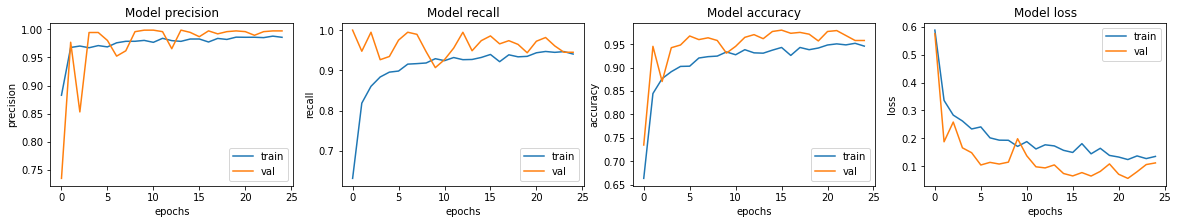

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [69]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

63/63 [==============================] - 4s 69ms/step - loss: 0.5582 - accuracy: 0.8526 - precision: 0.8268 - recall: 0.9667
Loss: 0.5581503510475159,
Accuracy: 0.8525640964508057,
Precision: 0.8267543911933899,
Recall: 0.9666666388511658


제시된 코드로만 실행했을 때 나온 결과를 저장해놓지 않았다. 
첫 번째 시도한 결과로 

<첫 번째 시도>
변경사항
1. 배치값 16 -> 10변경
2. augmentation 좌우 반전 추가
3. 활성화 함수 'ReLU' -> 'LeakyReLU' 로 변경 # 많이 사용하진 않지만 ReLU보다 더 좋은 성능을 보일 때도 있다고 해서 사용

실행 결과:
63/63 [==============================] - 5s 73ms/step - loss: 1.4792 - accuracy: 0.8013 - precision: 0.7628 - recall: 0.9897
Loss: 1.47918701171875,
Accuracy: 0.8012820482254028,
Precision: 0.7628458738327026,
Recall: 0.9897435903549194

<두번째 시도>
1. 생각보다 Accuracy가 좋지 않아서 augmentation 좌우 반전은 뺐다. 
2. 많이 사용하는 알고리즘 말고 모델에 맞는 최적화 알고리즘을 찾고 싶어서 최적화 optimization를 'adam'-> 'SGD' 변경해 보았다.
3. 배치값 16 -> 10변경/ 활성화 함수 'ReLU' -> 'LeakyReLU' 로 변경 유지

실행 결과:
63/63 [==============================] - 4s 69ms/step - loss: 0.5582 - accuracy: 0.8526 - precision: 0.8268 - recall: 0.9667
Loss: 0.5581503510475159,
Accuracy: 0.8525640964508057,
Precision: 0.8267543911933899,
Recall: 0.9666666388511658

Accuracy: 0.85 넘었기 때문에.. 그만해야겠다 ㅎ

회고

1. 활성화 함수 사용시에 relu에서 다른걸로 바꿔본다는 생각을 못 했는데 이번 노드에서는 찾아보고 바꿔서 시도해 보았던 점이 좋았다. 내가 사용한 Leaky relu는 relu의 knockout 문제점을 해결해주는 활성화 함수였는데 연산비용이 더 크고 실제로는 knockout 문제가 거의 발생하지 않기 때문에 relu를 많이 사용한다는 것을 배울 수 있었다. 
2. augmentation 추가에 대해 배울 수 있어서 좋았다. 데이터가 부족한 경우에 어떤 방식으로 데이터를 보충해서 쓰는지 코드와 출력되는 이미지를 보며 자세하게 알 수 있었고, 의료영상에는 사용하는게 조심스럽다는 것도 알 수 있었다. 실제로 이게 없으니까 정확도도 눈에 띄게 올라가는걸 확인할 수 있었다. 그래도 적당한 방법을 사용하면 적용할 수도 있었겠지 싶기도 하다.
3. 의료영상 처리에 관심이 있는데 이번 노드 정말 재미있었다.

참고자료

https://balmostory.tistory.com/52

https://sevillabk.github.io/1-batch-epoch/

https://www.tensorflow.org/tutorials/images/data_augmentation?hl=ko